<a href="https://colab.research.google.com/github/AgnesElza/cookie-cats-ab-testing/blob/main/cookie_cats_ab_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset Description — Cookie Cats A/B Test

The dataset comes from an A/B test run in **Cookie Cats**, a popular mobile puzzle game. The game introduces "gates" at certain levels, which slow player progression.  
We evaluated whether moving the game’s first gate from level 30 to level 40 increased player retention without harming long-term engagement.  

### Features

- **`userid`** *(int)*  
  Unique identifier for each player. Used for random assignment into control and treatment groups.  

- **`version`** *(string)*  
  Experimental group assignment:  
  - `gate_30` → Control group (gate placed at level 30).  
  - `gate_40` → Treatment group (gate placed at level 40).  

- **`sum_gamerounds`** *(int)*  
  Total number of game rounds played by the user during the 14-day observation period.  
  Serves as a proxy for **player engagement** and can be used as a covariate for variance reduction (CUPED).  

- **`retention_1`** *(bool)*  
  Indicates whether the player returned to the game **1 day** after installing.  
  - `True` → player came back on Day 1.  
  - `False` → player did not return.  
  This is the **short-term retention metric**.  

- **`retention_7`** *(bool)*  
  Indicates whether the player returned to the game **7 days** after installing.  
  - `True` → player came back on Day 7.  
  - `False` → player did not return.  
  This is the **long-term retention metric**.  

### Experiment Goal
The main business question is:  
> *Does moving the first gate from level 30 to level 40 increase short-term or long-term player retention?*

## Load data

In [ ]:
# Mounting Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# lifelines is a Python library for survival analysis
!pip install lifelines --quiet

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import scipy.stats as stats
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from scipy.optimize import brentq

In [ ]:
# Path to your data
data_path = "/content/drive/MyDrive/data_science_projects/cookie_cats_project/data"
df = pd.read_csv(f"{data_path}/cookie_cats.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


## SRM (Sample Ratio Mismatch) check

In [ ]:
df["version"].value_counts(normalize=True)

,proportion
version,
gate_40,0.504374
gate_30,0.495626


The split is essentially 50/50, which is what we expect from a properly randomized A/B test. Randomization looks good, no evidence of sample ratio msmatch. Let's move forward to outcome analysis.

In [ ]:
# Count users in each group
counts = df["version"].value_counts()
n_t = counts["gate_40"]
n_c = counts["gate_30"]
total = n_t + n_c

# Expected counts (50/50 split)
expected = [0.5 * total, 0.5 * total]

# Chi-square test
chi2, p, _, _ = chi2_contingency([[n_t, n_c], expected])

print("=== SRM Test ===")
print(f"Observed: gate_40 = {n_t:,} ({n_t/total:.2%}), gate_30 = {n_c:,} ({n_c/total:.2%})")
print(f"Expected: 50/50 split")
print(f"Chi-square = {chi2:.3f}, p-value = {p:.3f}")

if p < 0.01:
    print("⚠️ Possible sample ratio mismatch (p < 0.01)")
else:
    print("No SRM detected (groups are balanced as expected)")


=== SRM Test ===
Observed: gate_40 = 45,489 (50.44%), gate_30 = 44,700 (49.56%)
Expected: 50/50 split
Chi-square = 3.434, p-value = 0.064
No SRM detected (groups are balanced as expected)


The control and treatment groups were split ~50/50 with no evidence of sample ratio mismatch, confirming the experiment was properly randomized

## A/B Test Results: Day-1 and Day-7 Retention

The analysis here uses a two-proportion z-test, the standard frequentist method for comparing binary outcomes (retention rates) between treatment and control groups

In [ ]:
# two-proportion z-test
def ab_test_outcome(df, group_col, outcome_col, t_label, c_label, metric_name):
    y_t = df.loc[df[group_col]==t_label, outcome_col]
    y_c = df.loc[df[group_col]==c_label, outcome_col]

    p_t, p_c = y_t.mean(), y_c.mean()
    diff = p_t - p_c
    z = norm.ppf(0.975)
    # standard error (SE) of the difference in proportions
    se = np.sqrt(p_t*(1-p_t)/len(y_t) + p_c*(1-p_c)/len(y_c))
    ci = (diff - z*se, diff + z*se)

    print(f"\n=== {metric_name} ===")
    print(f"T = {p_t:.2%} [n={len(y_t):,}], C = {p_c:.2%} [n={len(y_c):,}]")
    print(f"Lift = {diff:.2%}, 95% CI = ({ci[0]:.2%}, {ci[1]:.2%})")
    if ci[0] > 0:
        print("Decision: 🚀 Ship")
    elif ci[1] < 0:
        print("Decision: ❌ Do not ship")
    else:
        print("Decision: 🤔 Inconclusive")

In [ ]:
ab_test_outcome(df, "version", "retention_1", "gate_40", "gate_30", "Day 1 retention")
ab_test_outcome(df, "version", "retention_7", "gate_40", "gate_30", "Day 7 retention")


=== Day 1 retention ===
T = 44.23% [n=45,489], C = 44.82% [n=44,700]
Lift = -0.59%, 95% CI = (-1.24%, 0.06%)
Decision: 🤔 Inconclusive

=== Day 7 retention ===
T = 18.20% [n=45,489], C = 19.02% [n=44,700]
Lift = -0.82%, 95% CI = (-1.33%, -0.31%)
Decision: ❌ Do not ship


The gate change did not clearly affect Day-1 retention, but it significantly reduced Day-7 retention — indicating that the new design hurts long-term player retention.

## Why We Cannot Apply CUPED Here

CUPED (Controlled-experiment Using Pre-Experiment Data) is a variance reduction technique.  
It works by adjusting the outcome using **pre-treatment covariates** that are:

1. **Measured before the experiment starts**  
2. **Correlated with the outcome**  

### Why it doesn’t work here
In the Cookie Cats dataset we have:
- `userid` → identifier  
- `version` → treatment assignment (gate_30 vs gate_40)  
- `sum_gamerounds` → total rounds played during the 14-day test window  
- `retention_1`, `retention_7` → post-treatment retention outcomes  

The only continuous variable available, **`sum_gamerounds`**, is measured **after randomization**.  
This means it may already be influenced by the treatment (moving the gate later).  

⚠️ If we used `sum_gamerounds` in CUPED, we would risk **blocking part of the treatment effect**  
→ the adjustment would introduce bias instead of just reducing variance.

## Guardrail Analysis (play rounds, engagement)

### What are guardrails?

Guardrail metrics are things you don’t want to harm while running an experiment.

Example in Cookie Cats:

- Primary metric = retention (retention_1, retention_7).

- Guardrail metric = engagement (sum_gamerounds).

Even if retention improves, we don’t want the change to reduce play rounds (which could hurt revenue or player experience).

In [ ]:
def ab_test_guardrail(df, group_col, metric_col, t_label, c_label, metric_name):
    y_t = df.loc[df[group_col]==t_label, metric_col]
    y_c = df.loc[df[group_col]==c_label, metric_col]

    mean_t, mean_c = y_t.mean(), y_c.mean()
    diff = mean_t - mean_c

    # Standard error for difference in means (Welch’s approx)
    se = np.sqrt(y_t.var(ddof=1)/len(y_t) + y_c.var(ddof=1)/len(y_c))
    z = norm.ppf(0.975)
    ci = (diff - z*se, diff + z*se)

    print(f"\n=== Guardrail: {metric_name} ===")
    print(f"T = {mean_t:.2f} rounds [n={len(y_t):,}], "
          f"C = {mean_c:.2f} rounds [n={len(y_c):,}]")
    print(f"Diff = {diff:.2f} rounds, 95% CI = ({ci[0]:.2f}, {ci[1]:.2f})")
    if ci[0] > 0:
        print("✅ Treatment increased engagement")
    elif ci[1] < 0:
        print("⚠️ Treatment decreased engagement")
    else:
        print("🤔 No significant difference in engagement")

# Run guardrail analysis on play rounds
ab_test_guardrail(df, "version", "sum_gamerounds", "gate_40", "gate_30", "Total game rounds played")



=== Guardrail: Total game rounds played ===
T = 51.30 rounds [n=45,489], C = 52.46 rounds [n=44,700]
Diff = -1.16 rounds, 95% CI = (-3.72, 1.40)
🤔 No significant difference in engagement


The new gate design did not significantly impact engagement — players in both groups played roughly the same number of rounds. Since retention was affected but engagement stayed stable, the retention effect is not explained by players playing more or fewer rounds overall.

## Subgroup (Heterogeneous Treatment Effect) Analysis

Even if the overall effect looks positive, different types of users may respond differently:

- Casual players (few rounds)

- Heavy players (lots of rounds)

👉 This helps answer:
“Does moving the gate help all players, or mainly one type?”

We’ll use sum_gamerounds to split players into Casual vs Heavy.
For simplicity, let’s use the median split (you could also use quartiles).

In [ ]:
# Define median split
median_rounds = df["sum_gamerounds"].median()

df["player_type"] = np.where(df["sum_gamerounds"] <= median_rounds,
                             "Casual", "Heavy")

df["player_type"].value_counts()

,count
player_type,
Casual,45114
Heavy,45075


In [ ]:
# Run subgroup analysis
for subgroup in ["Casual", "Heavy"]:
    print(f"\n*** Subgroup: {subgroup} players ***")
    sub_df = df[df["player_type"]==subgroup]
    ab_test_outcome(sub_df, "version", "retention_1", "gate_40", "gate_30", "Day 1 retention")
    ab_test_outcome(sub_df, "version", "retention_7", "gate_40", "gate_30", "Day 7 retention")


*** Subgroup: Casual players ***

=== Day 1 retention ===
T = 16.15% [n=22,945], C = 16.14% [n=22,169]
Lift = 0.02%, 95% CI = (-0.66%, 0.70%)
Decision: 🤔 Inconclusive

=== Day 7 retention ===
T = 2.56% [n=22,945], C = 2.57% [n=22,169]
Lift = -0.01%, 95% CI = (-0.30%, 0.28%)
Decision: 🤔 Inconclusive

*** Subgroup: Heavy players ***

=== Day 1 retention ===
T = 72.80% [n=22,544], C = 73.04% [n=22,531]
Lift = -0.24%, 95% CI = (-1.06%, 0.58%)
Decision: 🤔 Inconclusive

=== Day 7 retention ===
T = 34.12% [n=22,544], C = 35.21% [n=22,531]
Lift = -1.09%, 95% CI = (-1.97%, -0.21%)
Decision: ❌ Do not ship


👉 For heavy players, moving the gate later clearly hurts long-term retention.

- Casual players: No measurable impact (retention unaffected).

- Heavy players: Significantly lower Day-7 retention in treatment → the new design makes loyal players less likely to stick around.

The negative effect of moving the gate from level 30 to 40 is driven entirely by heavy players, the game’s most valuable audience. Casual players are unaffected, but the loss of long-term engagement among heavy players is a strong reason not to ship the new gate design.

Let's visualise lift by subgroup

In [ ]:
def compute_lift_ci(df, group_col, outcome_col, t_label, c_label):
    y_t = df.loc[df[group_col]==t_label, outcome_col]
    y_c = df.loc[df[group_col]==c_label, outcome_col]

    p_t, p_c = y_t.mean(), y_c.mean()
    diff = p_t - p_c

    # Standard error of difference in proportions
    se = np.sqrt(p_t*(1-p_t)/len(y_t) + p_c*(1-p_c)/len(y_c))
    z = norm.ppf(0.975)  # 95% CI
    ci = (diff - z*se, diff + z*se)

    return diff, ci

In [ ]:
subgroups = ["Casual", "Heavy"]
outcomes = {"Day 1 retention": "retention_1",
            "Day 7 retention": "retention_7"}

results = []

for subgroup in subgroups:
    sub_df = df[df["player_type"]==subgroup]
    for outcome_name, outcome_col in outcomes.items():
        diff, ci = compute_lift_ci(sub_df, "version", outcome_col, "gate_40", "gate_30")
        results.append({
            "subgroup": subgroup,
            "outcome": outcome_name,
            "lift": diff * 100,  # convert to %
            "ci_low": ci[0] * 100,
            "ci_high": ci[1] * 100
        })

results_df = pd.DataFrame(results)

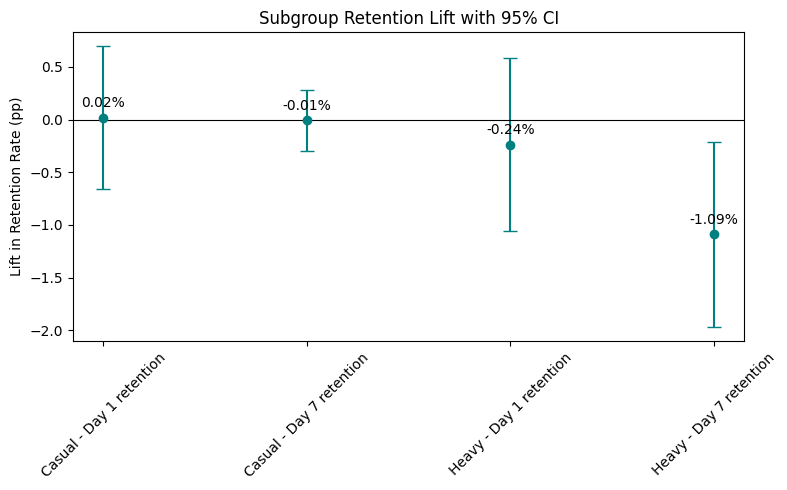

In [ ]:
plt.figure(figsize=(8,5))

for i, row in results_df.iterrows():
    plt.errorbar(
        x=i,
        y=row["lift"],
        yerr=[[row["lift"]-row["ci_low"]], [row["ci_high"]-row["lift"]]],
        fmt='o', capsize=5, color="teal"
    )
    plt.text(i, row["lift"]+0.1, f"{row['lift']:.2f}%", ha="center")

plt.axhline(0, color="black", linewidth=0.8)
plt.xticks(range(len(results_df)), results_df["subgroup"] + " - " + results_df["outcome"], rotation=45)
plt.ylabel("Lift in Retention Rate (pp)")
plt.title("Subgroup Retention Lift with 95% CI")
plt.tight_layout()
plt.show()

The treatment (gate at level 40) had no measurable impact on casual players, but it hurt long-term retention for heavy players, the game’s most engaged and valuable audience.

This explains why the overall result showed lower Day-7 retention: the effect is concentrated among heavy players.

## Survival Analysis

Instead of only looking at Day 1 and Day 7 snapshots, survival analysis lets us ask:

👉 “How long do players keep playing before they churn?”

Since Cookie Cats only gives us retention_1 and retention_7, we’ll simulate survival:

Treat Day 1 and Day 7 as “milestones”.

Build Kaplan–Meier curves.

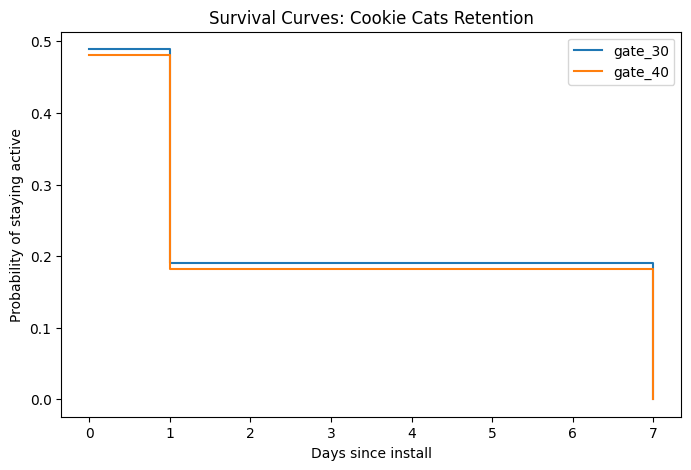

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# build simplified survival dataset
df["time"] = np.where(df["retention_7"]==1, 7,
               np.where(df["retention_1"]==1, 1, 0))
df["event"] = 1  # everyone eventually churns

# fit Kaplan–Meier curves
kmf = KaplanMeierFitter()

plt.figure(figsize=(8,5))
for group in df['version'].unique():
    mask = df['version'] == group
    kmf.fit(df.loc[mask, "time"], event_observed=df.loc[mask, "event"], label=group)
    kmf.plot_survival_function(ci_show=False)

plt.title("Survival Curves: Cookie Cats Retention")
plt.xlabel("Days since install")
plt.ylabel("Probability of staying active")
plt.show()

Moving the gate later (to level 40) did not help players stick around longer.

If anything, it slightly worsened retention — players in the treatment group leave the game earlier than those in control.

This dynamic survival view reinforces the Day-7 retention results: the gate_30 design is better for long-term retention.


## Power Analysis / Minimum Detectable Effect (MDE)

Power analysis answers:

👉 “Given my sample size, what’s the smallest effect I can detect?”

In [ ]:
analysis = NormalIndPower()

# Inputs
alpha = 0.05   # significance level
power = 0.8    # desired power
n_t, n_c = df["version"].value_counts()
p_baseline = df.loc[df["version"]=="gate_30", "retention_7"].mean()

# MDE (minimum detectable effect, absolute difference)
mde = analysis.solve_power(
    effect_size=None,
    nobs1=n_t,
    alpha=alpha,
    power=power,
    ratio=n_c/n_t,
    alternative="two-sided"
)

print(f"Baseline Day 7 retention: {p_baseline:.2%}")
print(f"Minimum Detectable Effect (MDE) at 80% power: {mde:.2%}")

Baseline Day 7 retention: 19.02%
Minimum Detectable Effect (MDE) at 80% power: 1.87%


With ~90k players split across groups, you have 80% power to detect a difference of ~1.87 percentage points in Day-7 retention.

The observed difference in the test was ~0.8pp.

Since 0.8pp < 1.87pp → the experiment was technically underpowered to reliably detect such a small effect.

👉 “How many players would we need to detect a 0.8pp effect at 80% power?”

In [ ]:
analysis = NormalIndPower()
alpha, power = 0.05, 0.80
p1 = df.loc[df["version"]=="gate_30", "retention_7"].mean()  # baseline (control)
ratio = 1.0

# 1) solve for Cohen's h (this is what solve_power returns)
h_mde = analysis.solve_power(effect_size=None, nobs1=len(df[df["version"]=="gate_40"]),
                             alpha=alpha, power=power, ratio=ratio, alternative="two-sided")

# 2) convert h -> p2, then MDE in percentage points
def h_to_p2(p1, h):
    f = lambda p2: 2*np.arcsin(np.sqrt(p2)) - 2*np.arcsin(np.sqrt(p1)) - h
    return brentq(f, 1e-9, 1-1e-9)

p2 = h_to_p2(p1, h_mde)
mde_abs = p2 - p1

print(f"Baseline (p1): {p1:.2%}")
print(f"MDE (Cohen's h): {h_mde:.4f}")
print(f"MDE (absolute pp): {mde_abs*100:.2f} pp")

Baseline (p1): 19.02%
MDE (Cohen's h): 0.0186
MDE (absolute pp): 0.73 pp


In [ ]:
p1 = df.loc[df["version"]=="gate_30", "retention_7"].mean()   # baseline
p2 = df.loc[df["version"]=="gate_40", "retention_7"].mean()   # treatment
n1 = (df["version"]=="gate_30").sum()
n2 = (df["version"]=="gate_40").sum()
ratio = n2 / n1

h = proportion_effectsize(p1, p2)
power = NormalIndPower().power(effect_size=abs(h), nobs1=n1, alpha=0.05, ratio=ratio, alternative='two-sided')
print(f"Observed diff: {(p2-p1)*100:.2f} pp  |  Achieved power: {power:.3f}")

Observed diff: -0.82 pp  |  Achieved power: 0.886


The experiment detected that moving the gate to level 40 reduces Day-7 retention by ~0.8pp. With nearly 89% statistical power, we can be confident this negative effect is genuine. The new design should not be shipped

## Bayesian take: probability treatment is better

In [ ]:
# --- Bayesian continuation (drop-in cell) ---

# 1) successes (k) and sample sizes (n) for Day-7 retention
RET_COL = "retention_7"
VAR_COL = "version"

g = df.groupby(VAR_COL)[RET_COL]
k = g.sum()      # successes per group (retained on day 7)
n = g.count()    # total per group

# 2) set control/treatment labels (edit here if your labels differ)
ctrl, trt = "gate_30", "gate_40"

# quick sanity print
print("Day7 rates:",
      {ctrl: f"{(k[ctrl]/n[ctrl]):.2%}",
       trt:  f"{(k[trt]/n[trt]):.2%}"})

# 3) Beta-Binomial posteriors (weakly-informative prior Beta(1,1))
a0 = b0 = 1
post_ctrl = stats.beta(a0 + k[ctrl], b0 + n[ctrl] - k[ctrl])
post_trt  = stats.beta(a0 + k[trt],  b0 + n[trt]  - k[trt])

# 4) Monte Carlo: P(p_trt > p_ctrl), posterior diff & lift
samps = 200_000
rng1, rng2 = np.random.default_rng(42), np.random.default_rng(43)
p_c_s = post_ctrl.rvs(samps, random_state=rng1)
p_t_s = post_trt.rvs(samps,  random_state=rng2)

prob_better   = np.mean(p_t_s > p_c_s)
diff_samples  = p_t_s - p_c_s                          # absolute pp difference
lift_samples  = diff_samples / np.clip(p_c_s, 1e-9, None)

# 5) credible intervals
diff_cri = np.percentile(diff_samples, [2.5, 50, 97.5])
lift_cri = np.percentile(lift_samples, [2.5, 50, 97.5])

print(f"\nBayesian results (Beta-Binomial, prior Beta(1,1))")
print(f"P(treatment > control) = {prob_better:.3f}")
print(f"Posterior abs diff (pp): median {diff_cri[1]*100:.2f} "
      f"CrI [{diff_cri[0]*100:.2f}, {diff_cri[2]*100:.2f}]")
print(f"Posterior lift (%):      median {lift_cri[1]*100:.2f} "
      f"CrI [{lift_cri[0]*100:.2f}, {lift_cri[2]*100:.2f}]")

# 6) optional: tidy dict if you want to store/print later
bayes_summary = {
    "p_treatment_gt_control": float(prob_better),
    "abs_diff_median_pp":     float(diff_cri[1]*100),
    "abs_diff_95CrI_pp":      [float(diff_cri[0]*100), float(diff_cri[2]*100)],
    "lift_median_pct":        float(lift_cri[1]*100),
    "lift_95CrI_pct":         [float(lift_cri[0]*100), float(lift_cri[2]*100)]
}
bayes_summary

Day7 rates: {'gate_30': '19.02%', 'gate_40': '18.20%'}

Bayesian results (Beta-Binomial, prior Beta(1,1))
P(treatment > control) = 0.001
Posterior abs diff (pp): median -0.82 CrI [-1.33, -0.31]
Posterior lift (%):      median -4.31 CrI [-6.90, -1.65]


{'p_treatment_gt_control': 0.000835,
 'abs_diff_median_pp': -0.819031534349103,
 'abs_diff_95CrI_pp': [-1.3290897271147746, -0.3102176728530588],
 'lift_median_pct': -4.305528612785688,
 'lift_95CrI_pct': [-6.895272723014203, -1.653605799507773]}

## Choosing the Right Statistical Test in A/B Testing

| Outcome type                                                             | Sample size (n)                        | Recommended test                                                                | Notes                                                      |
| ------------------------------------------------------------------------ | -------------------------------------- | ------------------------------------------------------------------------------- | ---------------------------------------------------------- |
| **Binary outcome** (e.g., retention yes/no, click-through)               | **Small (n < 30 per group)**           | Fisher’s Exact Test                                                             | Exact test for proportions, works with tiny samples.       |
|                                                                          | **Medium to Large (n ≥ 30 per group)** | Two-proportion **z-test**                                                       | Standard for A/B testing when sample sizes are big enough. |
| **Continuous outcome** (e.g., revenue, session length)                   | **Small (n < 30 per group)**           | Two-sample **t-test** (Welch’s t-test)                                          | Accounts for extra uncertainty with small n.               |
|                                                                          | **Large (n ≥ 30 per group)**           | **t-test** ≈ **z-test**                                                         | With large samples, t- and z-tests converge.               |
| **Non-normal / skewed continuous outcome** (e.g., spend with many zeros) | Any size                               | **Bootstrap confidence intervals** or log-transform + t-test                    | Robust to skewness and heavy tails.                        |
| **Sequential / adaptive experiments**                                    | Any size                               | **Sequential tests** (alpha-spending, group sequential) or **Bayesian** methods | Handles repeated peeking and adaptive allocation.          |
